In [771]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
import os
import glob


In [772]:
def clean_df(df:pd.DataFrame):
    df = df.fillna(value=np.nan)
    return df[(np.abs(stats.zscore(df, nan_policy='omit')) < 3).all(axis=1)] 


In [773]:
def create_CPU_limited_execution_time_df_for_program(program_directory:Path):
    execution_time_stats_directory=Path(program_directory, "run_stats", "execution_times_CPU_limited")
    execution_time_for_CPU_limit={}
    for stats_file in list(execution_time_stats_directory.glob('*.csv')):
        stats_file_df=pd.read_csv(stats_file)
        CPU_limits=stats_file_df['CPULimit'][0]*100 #CPU converted to percentage
        execution_time_for_CPU_limit[CPU_limits]=stats_file_df['ExecutionTime'].tolist()[1:]
    execution_time_for_CPU_df=pd.DataFrame(execution_time_for_CPU_limit).transpose()
    execution_time_for_CPU_df.sort_index(inplace=True)
    return clean_df(execution_time_for_CPU_df)


In [774]:
def create_memory_limited_execution_time_df_for_program(program_directory:Path):
    execution_time_stats_directory=Path(program_directory, "run_stats", "execution_times_memory_limited")
    execution_time_for_memory_limit={}
    for stats_file in list(execution_time_stats_directory.glob('*.csv')):
        stats_file_df=pd.read_csv(stats_file)
        
        memory_limits=stats_file_df['MemoryLimit'][0]
        
        execution_time_for_memory_limit[memory_limits]=stats_file_df['ExecutionTime'].tolist()[1:]
    execution_time_for_memory_df=pd.DataFrame(execution_time_for_memory_limit).transpose()
    execution_time_for_memory_df.sort_index(inplace=True)
    return clean_df(execution_time_for_memory_df)
    

In [775]:
def create_df_for_program(program_directory:Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    '''Returns dataframe with time series data for program execution. Run data down column, data for given second across rows '''
    time_series_stats_directory=Path(program_directory, "run_stats", "time_series_stats")
    CPU_data=[]
    memory_data=[]
    for stats_file in list(time_series_stats_directory.glob('*.csv')):
        stats_file_df=pd.read_csv(stats_file, usecols=['CPU', 'MemUsage'])
        CPU_data.append(stats_file_df['CPU'].tolist())
        memory_data.append(stats_file_df['MemUsage'].tolist())
    CPU_df=pd.DataFrame(CPU_data).transpose()
    memory_data=pd.DataFrame(memory_data).transpose()
    memory_data=memory_data.div(1e+6) #convert from B to MB
    return (clean_df(CPU_df), clean_df(memory_data))

In [776]:
def process_CPU_utilisation(CPU_df:pd.DataFrame, execution_time_df:pd.DataFrame, program_title:str): #execution_time_df:pd.DataFrame, program_title:str):
    summary_stats_for_program={}    
    CPU_df.loc['run_mean']=CPU_df.mean() #mean value for run
    CPU_df['time_elapsed_mean']=CPU_df.mean(axis=1) #mean value for per second reading over replicant runs
    CPU_df.iloc[0:-1].plot(legend=False, ylim=(CPU_df.min().min()*0.9, CPU_df.max().max()*1.1), title=program_title+" CPU utilisation", xlabel="Time(s)", ylabel="CPU Utilisation (%)")
    summary_stats_for_program['MedianPeakCPU']=CPU_df.max().median() #mean of peak CPU values #Check accuracy on data!!
    summary_stats_for_program['OverallPeakCPU']=CPU_df.max().max() #maximum recorded CPU utilisation
    summary_stats_for_program['PeakCPUStdDev']=CPU_df.max().std() #std of peak CPU values
    summary_stats_for_program['MedianRunCPURange']=(CPU_df.max()-CPU_df.min()).median() #median across runs of the range in CPU recorded per run
    summary_stats_for_program['MedianCPUAcrossRuns']=CPU_df.loc['run_mean'].median()
    summary_stats_for_program['MedianPeakToMedianCPUDifference']=summary_stats_for_program['MedianPeakCPU']-summary_stats_for_program['MedianCPUAcrossRuns'] #mean difference between peak and mean cpu utilisation across runs 
    summary_stats_for_program['PeakToMedianCPUPercDiff']=(summary_stats_for_program['MedianPeakToMedianCPUDifference']/summary_stats_for_program['MedianCPUAcrossRuns'])*100 #mean difference between peak and mean cpu as a percentage of mean
    
    rounded_stats={stat : round(summary_stats_for_program[stat],2) for stat in summary_stats_for_program}
    rounded_stats["ProgramName"]=program_title
    print(rounded_stats)


    execution_time_df['limit_execution_time_mean']=execution_time_df.mean(axis=1)
    execution_time_plot_axes=execution_time_df.plot(y='limit_execution_time_mean', xlabel="CPU Limit (%)", ylabel="Mean Execution Time (s)", title=program_title+" Mean Execution Time for Limited CPU", legend=True)
    execution_time_plot_axes.axvline(x=rounded_stats['MedianCPUAcrossRuns'], linestyle="--", color='green')
    execution_time_plot_axes.lines[-1].set_label("Median CPU across runs in time series = %s" % (rounded_stats['MedianCPUAcrossRuns']))
    execution_time_plot_axes.axvline(x=rounded_stats['MedianPeakCPU'], linestyle="--", color='red')
    execution_time_plot_axes.lines[-1].set_label("Median peak CPU across runs in time series = %s" % (rounded_stats['MedianPeakCPU']))
    execution_time_plot_axes.legend(loc="upper left")

    


In [777]:
def process_memory_utilisation(memory_df:pd.DataFrame, execution_time_df:pd.DataFrame, program_title:str):
    summary_stats_for_program={}    
    memory_df.loc['run_mean']=memory_df.mean() #mean value for run
    memory_df['time_elapsed_mean']=memory_df.mean(axis=1) #mean value for per second reading over replicant runs
    memory_df.iloc[0:-1].plot(legend=False, title=program_title+" Memory utilisation", xlabel="Time(s)", ylabel="Memory Utilisation (MB)")
    summary_stats_for_program['MedianPeakMemory']=memory_df.max().median() #mean of peak CPU values #Check accuracy on data!!
    summary_stats_for_program['OverallPeakMemory']=memory_df.max().max() #maximum recorded CPU utilisation
    summary_stats_for_program['PeakMemoryStdDev']=memory_df.max().std() #std of peak CPU values
    summary_stats_for_program['MedianRunMemoryRange']=(memory_df.max()-memory_df.min()).median() #median across runs of the range in recorded memory use over a run
    summary_stats_for_program['MedianMemoryAcrossRuns']=memory_df.loc['run_mean'].median()
    summary_stats_for_program['MedianPeakToMedianMemoryDifference']=summary_stats_for_program['MedianPeakMemory']-summary_stats_for_program['MedianMemoryAcrossRuns'] #median difference between peak and median memory utilisation across runs 
    summary_stats_for_program['PeakToMedianMemoryPercDiff']=(summary_stats_for_program['MedianPeakToMedianMemoryDifference']/summary_stats_for_program['MedianMemoryAcrossRuns'])*100 #median difference between peak and median memory as a percentage of median
    rounded_stats={stat : round(summary_stats_for_program[stat],2) for stat in summary_stats_for_program}
    rounded_stats["ProgramName"]=program_title
    print(rounded_stats)

    execution_time_df['limit_execution_time_mean']=execution_time_df.mean(axis=1)
    execution_time_plot_axes = execution_time_df.plot(y='limit_execution_time_mean', xlabel="Memory Limit (MB)", ylabel="Mean Execution Time (s)", title=program_title+" Mean Execution Time for Limited Memory", legend=False)
    execution_time_plot_axes.axvline(x=rounded_stats['MedianMemoryAcrossRuns'], linestyle="--", color='green')
    execution_time_plot_axes.lines[-1].set_label("Median memory across runs in time series = %s" % (rounded_stats['MedianMemoryAcrossRuns']))
    execution_time_plot_axes.axvline(x=rounded_stats['MedianPeakMemory'], linestyle="--", color='red')
    execution_time_plot_axes.lines[-1].set_label("Median peak memory across runs in time series = %s" % (rounded_stats['MedianPeakMemory']))
    execution_time_plot_axes.legend(loc="upper left")

 

In [778]:
def process_program_stats(program_directory:Path):
    CPU_df, memory_df = create_df_for_program(program_directory)
    CPU_limited_execution_times_df=create_CPU_limited_execution_time_df_for_program(program_directory)
    memory_limited_execution_times_df=create_memory_limited_execution_time_df_for_program(program_directory)

  

    process_CPU_utilisation(CPU_df, CPU_limited_execution_times_df, program_directory.name)
    process_memory_utilisation(memory_df, memory_limited_execution_times_df, program_directory.name)

{'MedianPeakCPU': 263.53, 'OverallPeakCPU': 264.47, 'PeakCPUStdDev': 0.44, 'MedianRunCPURange': 3.06, 'MedianCPUAcrossRuns': 261.92, 'MedianPeakToMedianCPUDifference': 1.61, 'PeakToMedianCPUPercDiff': 0.62, 'ProgramName': 'hn__4.3.03__va_nFXnp12'}
{'MedianPeakMemory': 72.84, 'OverallPeakMemory': 73.08, 'PeakMemoryStdDev': 0.45, 'MedianRunMemoryRange': 72.44, 'MedianMemoryAcrossRuns': 36.67, 'MedianPeakToMedianMemoryDifference': 36.17, 'PeakToMedianMemoryPercDiff': 98.65, 'ProgramName': 'hn__4.3.03__va_nFXnp12'}
{'MedianPeakCPU': 35.17, 'OverallPeakCPU': 36.25, 'PeakCPUStdDev': 0.88, 'MedianRunCPURange': 28.53, 'MedianCPUAcrossRuns': 15.0, 'MedianPeakToMedianCPUDifference': 20.18, 'PeakToMedianCPUPercDiff': 134.54, 'ProgramName': 'prog1'}
{'MedianPeakMemory': 20317.0, 'OverallPeakMemory': 20390.0, 'PeakMemoryStdDev': 34.94, 'MedianRunMemoryRange': 20307.66, 'MedianMemoryAcrossRuns': 10542.08, 'MedianPeakToMedianMemoryDifference': 9774.92, 'PeakToMedianMemoryPercDiff': 92.72, 'ProgramNam

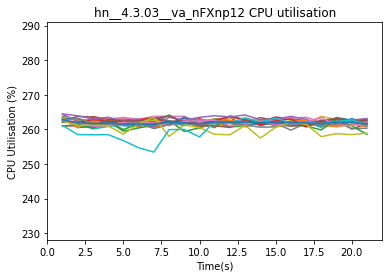

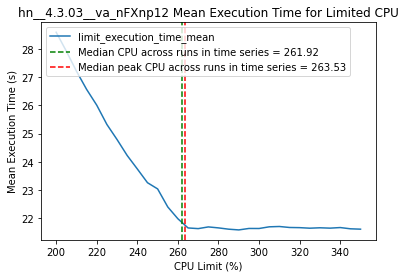

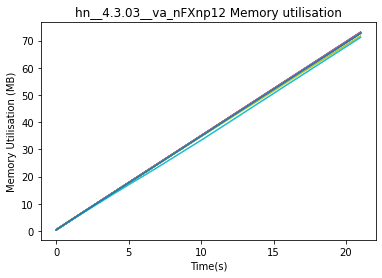

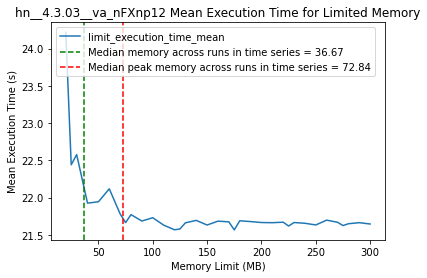

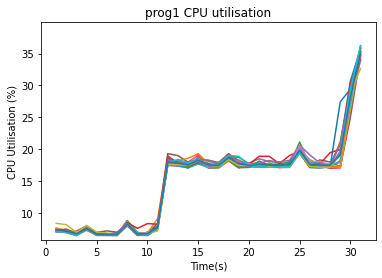

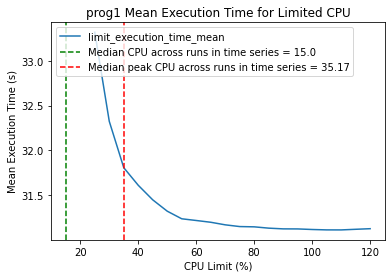

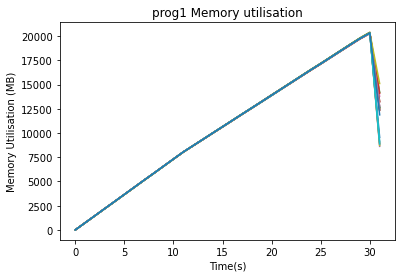

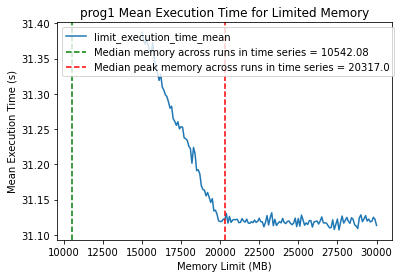

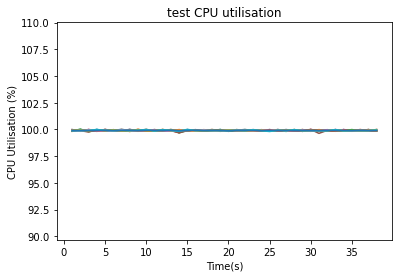

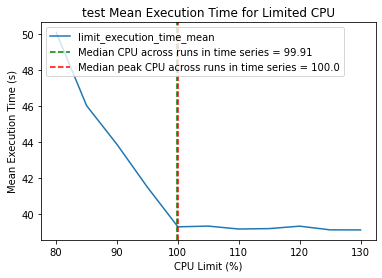

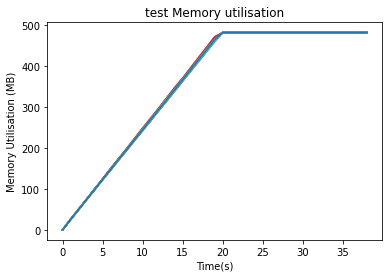

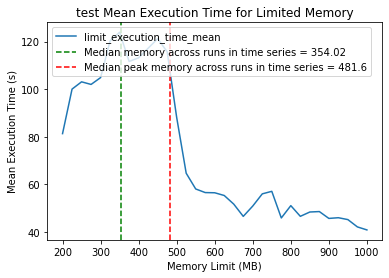

In [779]:
#main

path_to_data=Path(Path().resolve().parent, "data")
program_directories = [x for x in path_to_data.iterdir() if x.is_dir()]
for program_directory in program_directories:
    process_program_stats(program_directory)
